# Analyzing Spot Diffraction Pattern


part of 
## [MSE672- Introduction to Transmission Electron Microsocpy](_MSE672-IntroToTEM.ipynb)


## Chapter 2 [Diffraction](Diffraction.ipynb)

by Gerd Duscher, Fall 2018

## Import numerial and plotting python packages

In [30]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook


# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from the book
import os, sys
sys.path.append('./TEMlib')

import KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the image tool library of Quantifit
import file_tools as ft

Populating the interactive namespace from numpy and matplotlib


# Load Spot-Diffraction Pattern
## First we select the diffraction pattern

In [31]:
file_name= ''

dp1 = ipyw.Dropdown()
dp2 = ipyw.Dropdown()

def on_select(change):
    global file_name
    if change['type'] == 'change' and change['name'] == 'value':
        file_name=change['new']
dp2.observe(on_select)
current_directory_output = ipyw.Text('', disabled=True)
box1 = ipyw.HBox([ipyw.Label(value="Directory:"), current_directory_output, dp1 ])
box2 = ipyw.HBox([ipyw.Label(value=" File  :"), dp2])
display(box1)
display(box2)

ft.file_select(dp1,dp2,current_directory_output,'.')

HBox(children=(Label(value='Directory:'), Text(value='', disabled=True), Dropdown(options=(), value=None)))

HBox(children=(Label(value=' File  :'), Dropdown(options=(), value=None)))

## Now we load the diffraction pattern
Please note that we *transpose* the *image matrix* to make it look like on the screen on the TEM computer.

Also, the dynamic range of diffraction patterns is too high for computer screens and so we take the logarithm of the intensity. 

Found  image  in dm3 file
dict_keys(['filename', 'path', 'extension', 'basename', 'data_type', 'microscope', 'acceleration_voltage', 'aberrations', 'axis', 'pixel_size', 'FOV', 'shape', 'original_metadata', 'data'])
{'0': {'origin': 0.0, 'scale': 0.0295258816331625, 'units': 'nm'}, '1': {'origin': 0.0, 'scale': 0.0295258816331625, 'units': 'nm'}}


<IPython.core.display.Javascript object>


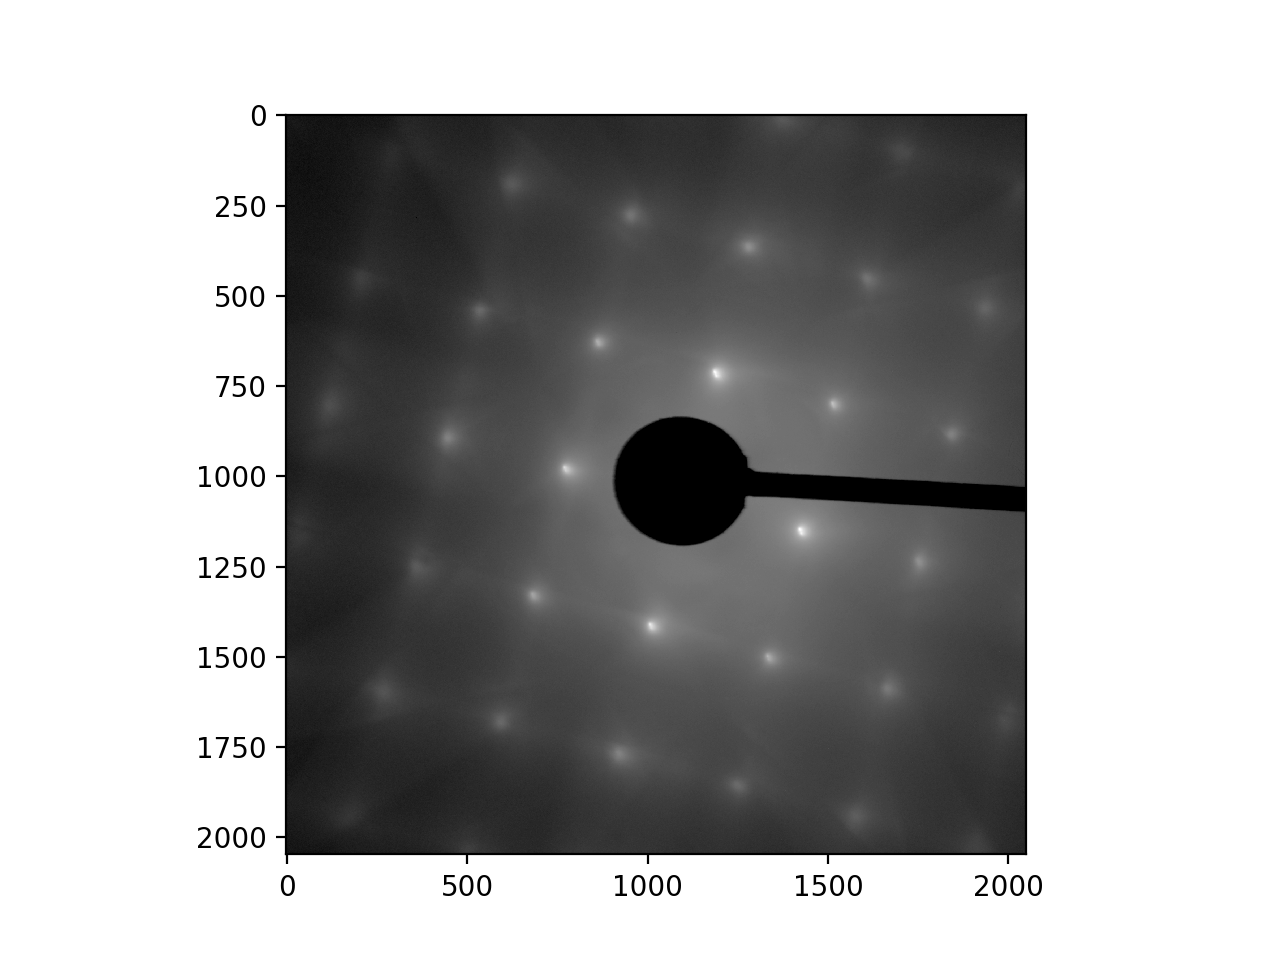

In [8]:
current_directory = os.getcwd()
pattern_tags = ft.open_file(os.path.join(current_directory,file_name))
print(pattern_tags.keys())
print (pattern_tags['axis'])

diff_pattern = pattern_tags['data'].T
below_zero = diff_pattern<0.
diff_pattern[below_zero] = 0.
fig = plt.figure() 
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5);
scale_300mm = 0.012829394079744816

# Finding the center

## First try with cross correlation of rotated images


# Cross- and Auto- Correlation

Cross correlation and auto correlation are based on a  multiplication in Fourier space. In the case of a an auto-correlation it is the same data while in the cross correlation it is another data (here the transposed (rotated) diffraction pattern)

<IPython.core.display.Javascript object>


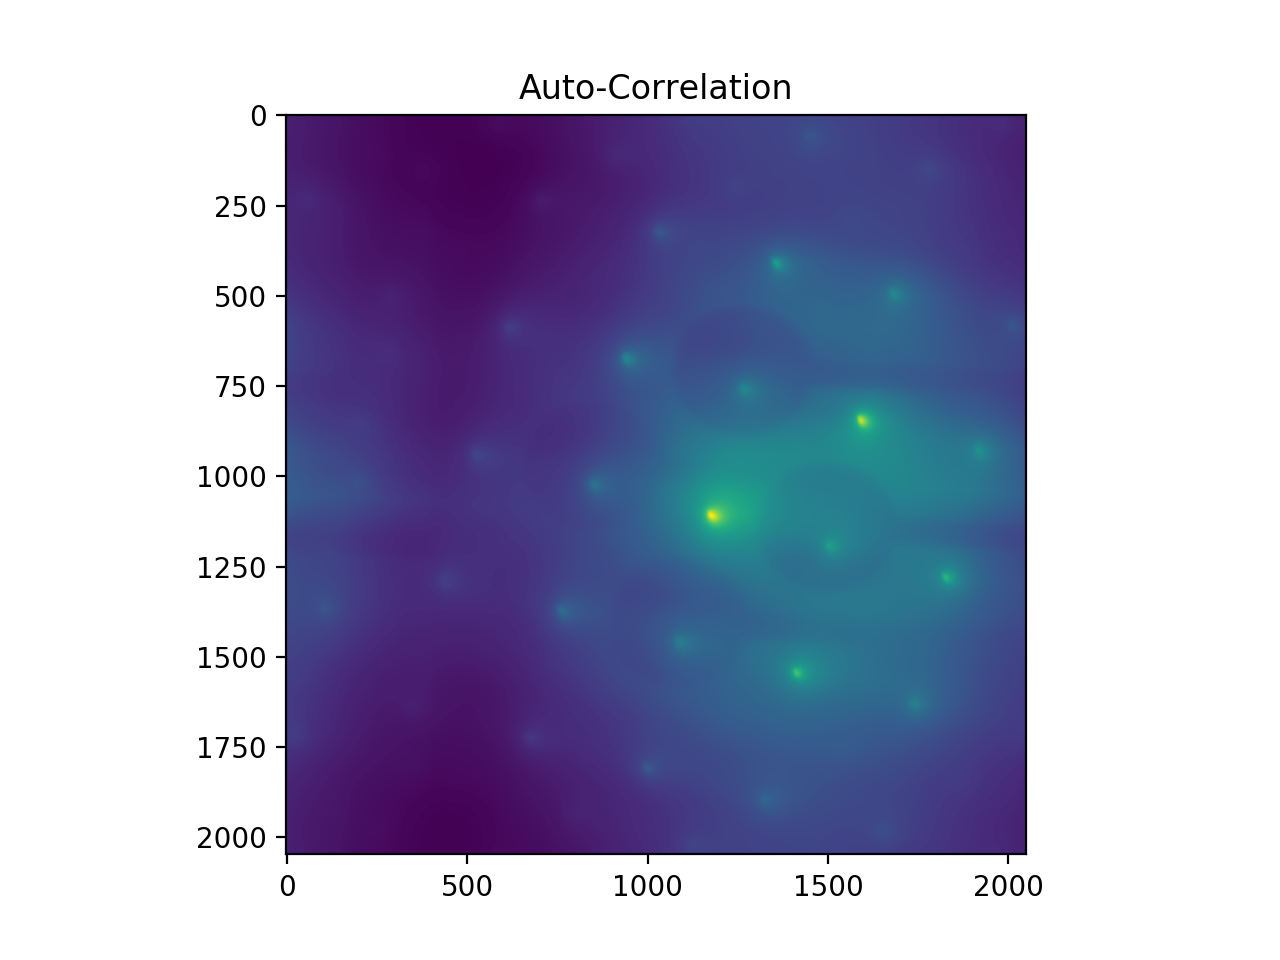

center = (1111, 1177) which is a shift of 87.0 px in x and 153.0 px in y direction


In [9]:
correlation = 'auto'
dif_ft = np.fft.fft2(diff_pattern)

if correlation == 'auto':
    auto_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft))
    center = np.unravel_index(np.argmax(auto_correlation.real, axis=None), auto_correlation.real.shape)
    plt.figure()
    plt.title('Auto-Correlation')
    plt.imshow(auto_correlation.real);
else:   
    dif_ft2 = np.fft.fft2(diff_pattern.T)
    cross_correlation  = np.fft.fftshift(np.fft.ifft2(dif_ft*dif_ft.T))
    center = np.unravel_index(np.argmax(cross_correlation.real, axis=None), cross_correlation.real.shape)
    plt.figure()
    plt.title('Cross-Correlation')
    plt.imshow(cross_correlation.real);
    
shift = np.array(center - np.array(dif_ft.shape)/2)
print(f'center = {center} which is a shift of {shift[0]} px in x and {shift[1]} px in y direction')


## How well did we do?

## Select the center yourself

The beam stop confuses the cross correlation sometimes and then we need to  adjust the selection

(1111, 1177)


<IPython.core.display.Javascript object>


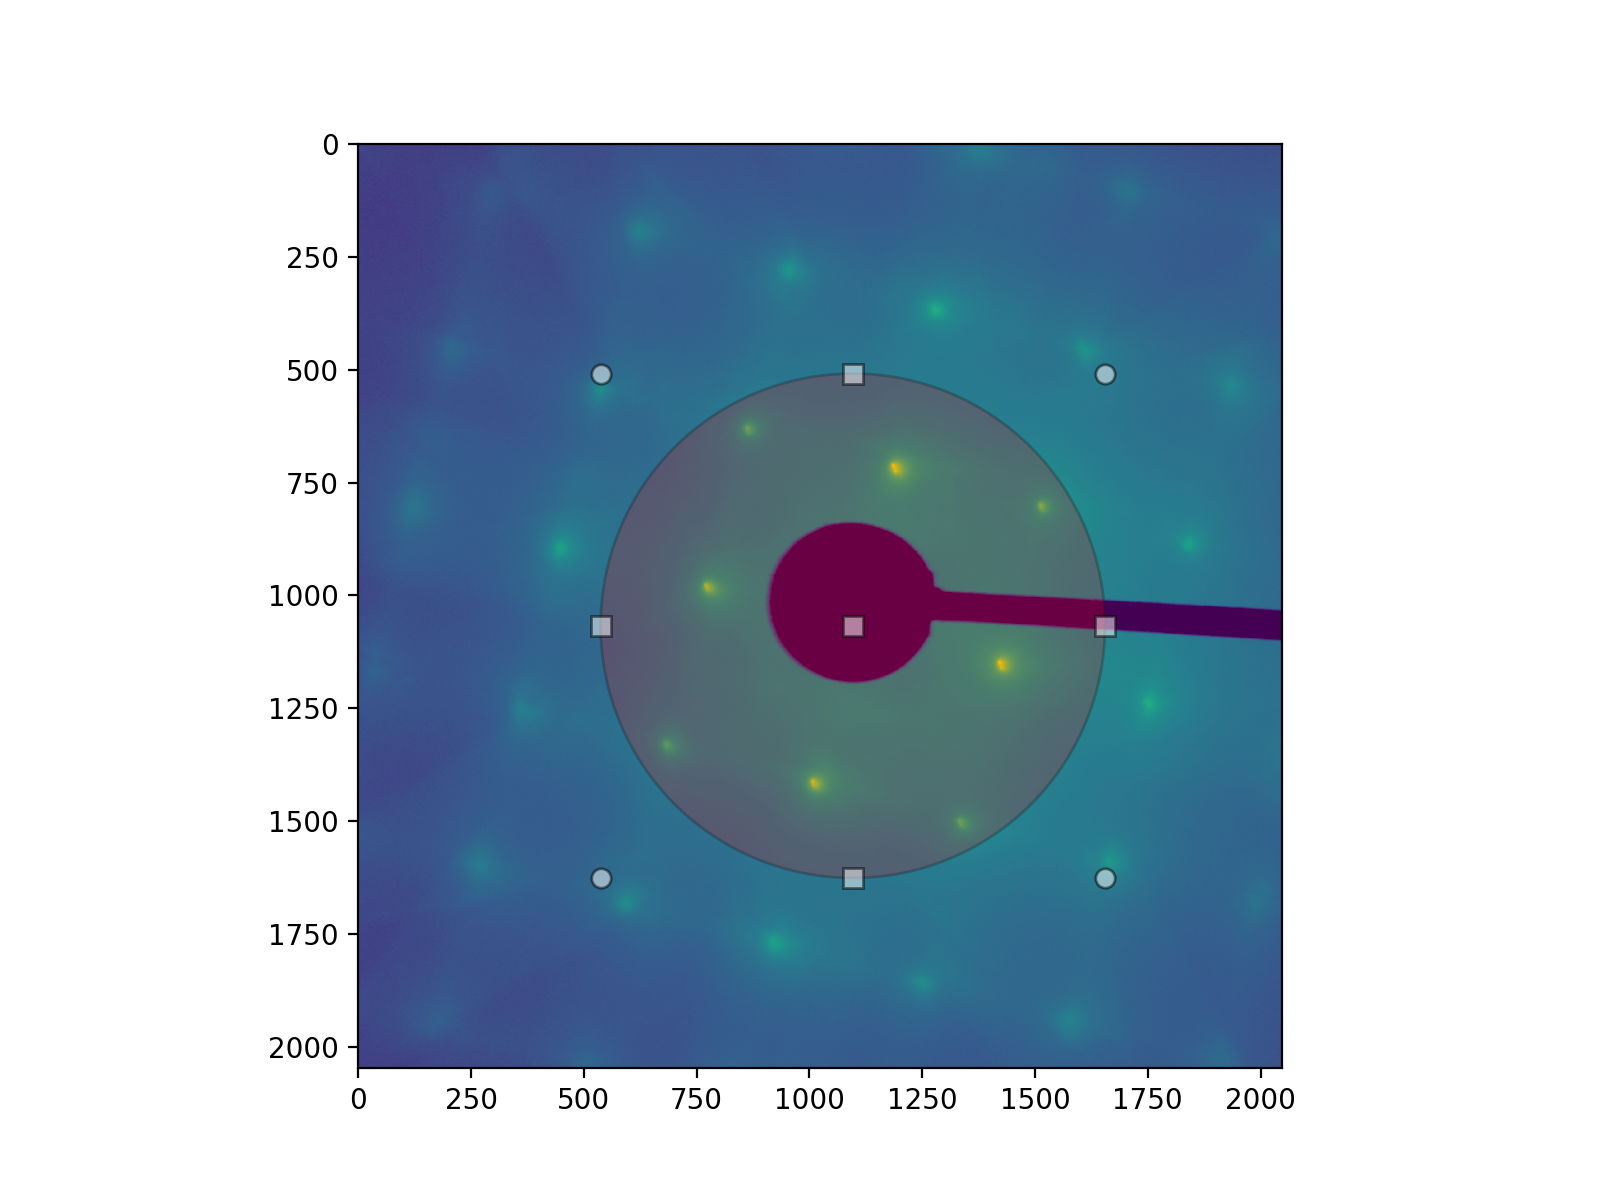

In [10]:
from matplotlib.widgets import  EllipseSelector

print(center)
#center[0]= 1056
#center[1]=1100
#new center = [1096.27347132 1067.31182359]
center = [1096.27347132, 1067.31182359]

plt.figure(figsize=(8, 6))
plt.imshow(np.log(1.+diff_pattern),vmin = np.max(np.log2(1+diff_pattern))*0.3)
selector = EllipseSelector(plt.gca(), None,interactive=True , drawtype='box')  # gca get current axis (plot)

selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)


In [11]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius = {(xmax-xmin)/2:.0f} pixels')

center = np.array((x_center, y_center ))
print(f'new center = {center} [pixels]')


radius = 559 pixels
new center = [1096.27347132 1067.31182359] [pixels]


# Determine Bragg Peaks

Peak finding is actually not as simple as it looks

In [12]:
# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

<IPython.core.display.Javascript object>


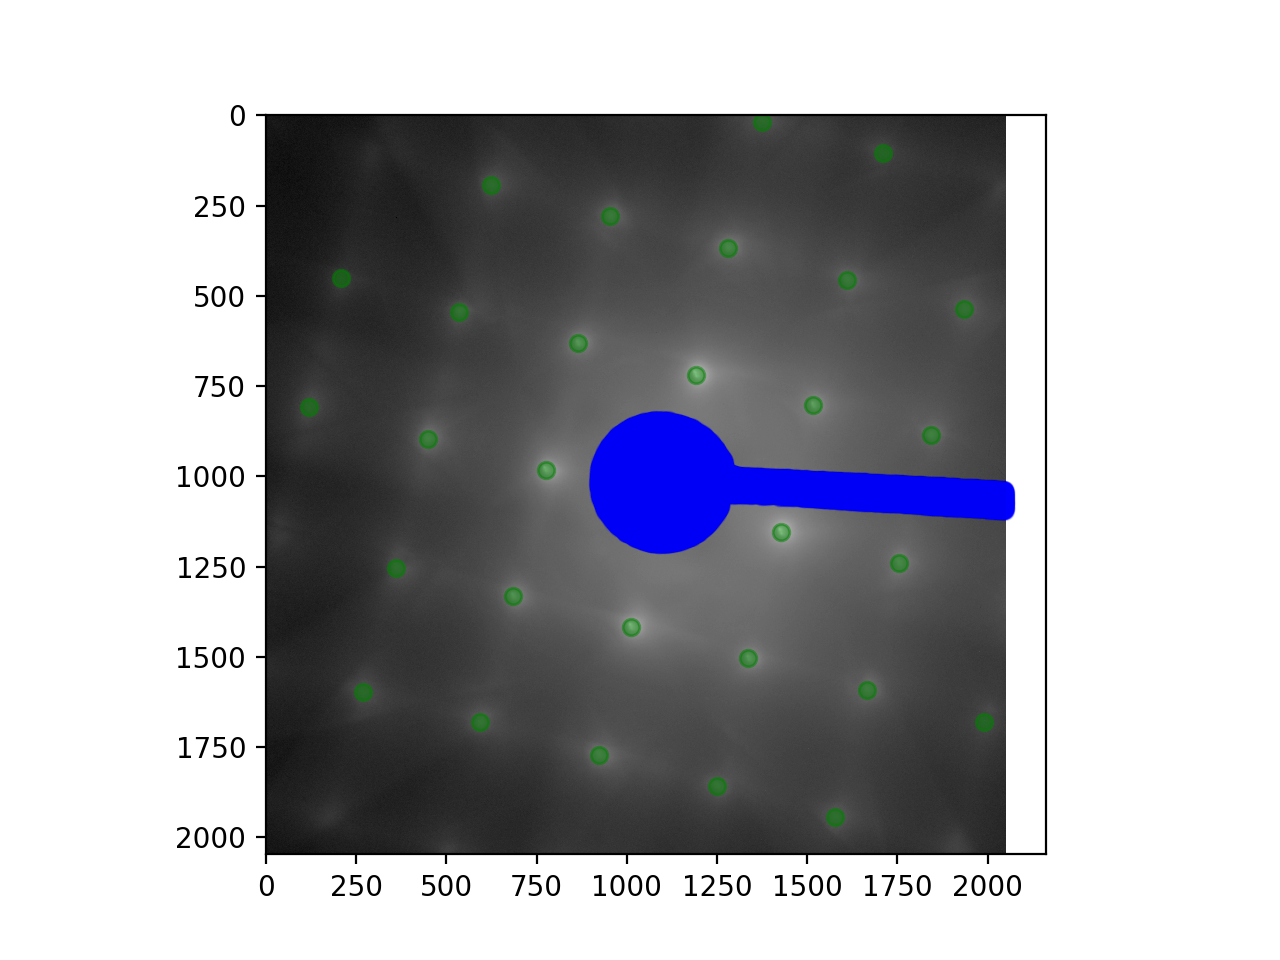

In [13]:

# The beam stop is rather dark
beam_stop = np.argwhere(diff_pattern < 50)

# Determine all spots
spots =  (blob_dog(np.log2(1+diff_pattern),  max_sigma=12 , threshold=.9))

Bragg_spots = []
plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)

# We only consider spots not associated with the beam stop (which confuses the blob finder)
for spot in spots:
    if np.min(np.linalg.norm(beam_stop-spot[0:2], axis=1))> 50:
        Bragg_spots.append(spot[0:2])
        plt.scatter(spot[1], spot[0], c='green',  alpha = 0.5)
plt.scatter(beam_stop[:,1], beam_stop[:,0], c='blue',  alpha = 0.1)   
Bragg_spots = np.array(Bragg_spots)
#print(np.array(Bragg_spots))    

## Now we plot with the right scale

<IPython.core.display.Javascript object>


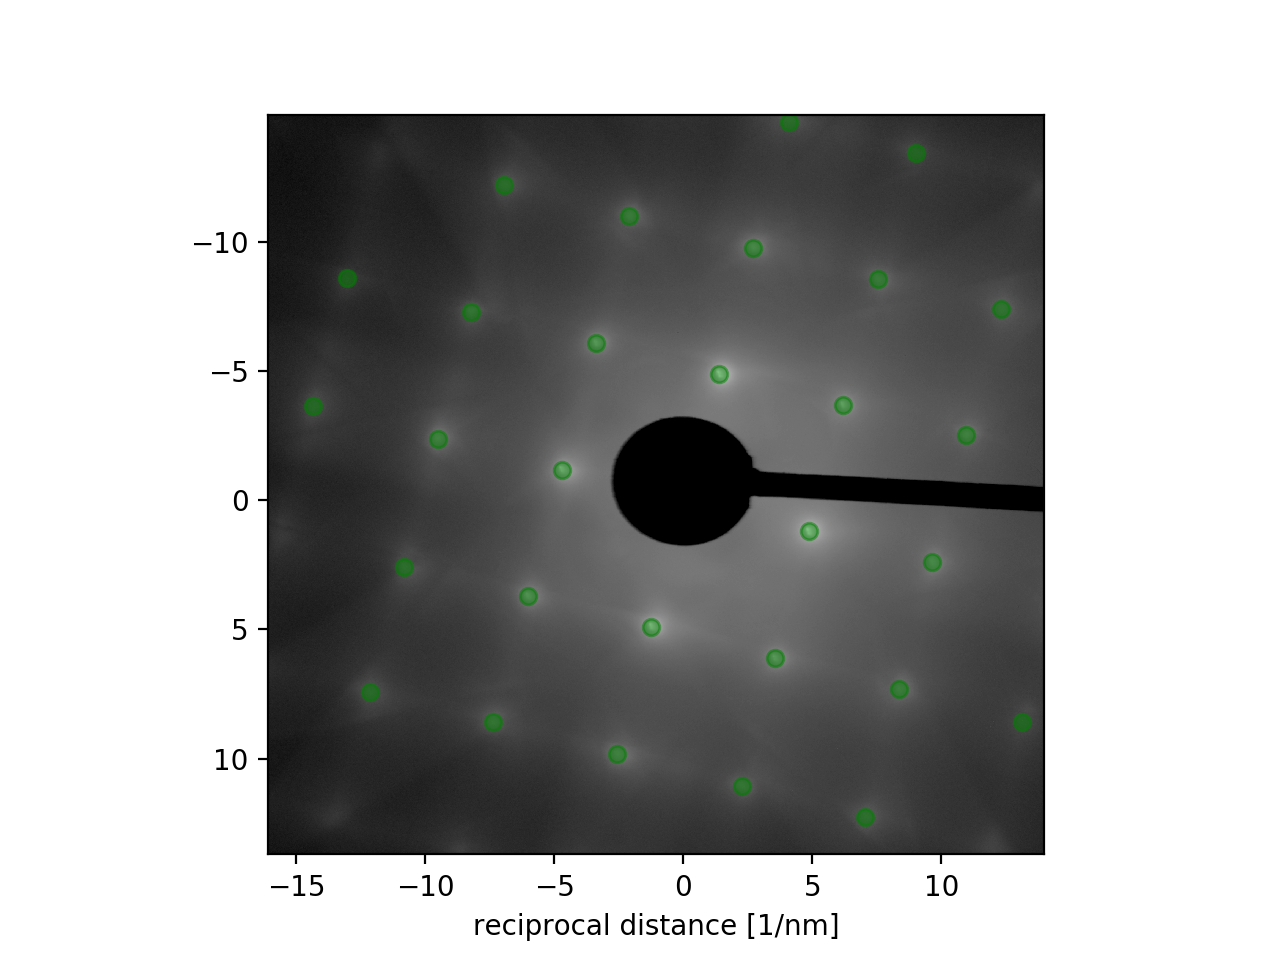

In [14]:
g = gx = gy = pattern_tags['axis']['0']['scale']
g = gx = gy = scale_300mm*1.09
gx = gy * 1.05

spots_experiment = (Bragg_spots-(center[1],center[0]))*(gy,gx)

fig = plt.figure()
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

plt.imshow(np.log2(1+diff_pattern),cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5)

plt.scatter(spots_experiment[:,1], spots_experiment[:,0], c='green',  alpha = 0.5,
           label='spots')
plt.xlabel('reciprocal distance [1/nm]');


# The norm of the reflections 
will show us how accurate our center was determined and what give us a first idea on what zone axis we have.
If the center is accurate, we should have always a number of spots with the same distance from center (norm of reciprocal lattice vetor) according to symmetery (in [001] direction always 4 reciprocal lattice vectors with the same length)

In [17]:
print(np.sort(np.linalg.norm(spots_experiment,axis=1)))

[ 4.8516184   5.00179116  5.04418468  5.07895253  6.98275461  7.05585394
  7.08292846  7.19893086  9.81558782  9.93726908 10.15795878 10.16766951
 11.01048457 11.11804075 11.11835652 11.21997673 11.23940251 11.28505842
 11.32602538 11.40158402 14.06329806 14.12703931 14.23462875 14.3756858
 14.78983849 15.21625272 15.63304029 15.67517069 16.19561873]


# Calculate Spot Pattern

see [Plotting of Diffraction Pattern](Plotting_Diffraction_Pattern.ipynb) for details


In [32]:
#Initialize the dictionary of the input
tags_simulation = {}
### Define Crystal
tags_simulation  = ks.structure_by_name('silicon')

### Define experimental parameters:
tags_simulation['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_simulation['new_figure'] = False
tags_simulation['plot FOV'] = 30
tags_simulation['convergence_angle_mrad'] = 0
tags_simulation['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_simulation['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_simulation['Sg_max'] = .4 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_simulation['hkl_max'] = 15   # Highest evaluated Miller indices

######################################
# Diffraction Simulation of Crystal #
######################################

ks.Kinematic_Scattering(tags_simulation, verbose = True)


reciprocal_unit_cell
[[1.764 0.    0.   ]
 [0.    1.764 0.   ]
 [0.    0.    1.764]]
The inner potential is 0.001kV
Magnitude of incident wave vector in material 398.7 1/nm and vacuum 398.7 1/nm
The convergence angle of 0mrad = 0.00 1/nm
Rotation angles are 0.0 deg and 90.0 deg
Center of Ewald sphere  [  0.           0.         398.73533752]
Of the 29790 tested reciprocal_unit_cell points, 364 have an excitation error less than 0.40 1/nm
Of the 364 possible reflection 48 are allowed.
 There are 36 allowed reflections in the zero order Laue Zone
 There are 12 allowed reflections in the first order Laue Zone
 There are 0 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the other higher order Laue Zones
Length of zone axis vector in real space 0.567 nm
There are 0 forbidden but dynamical activated diffraction spots:
KinsCat's  "Kinematic_Scattering" finished


# Plotting Experimental and Simulated Spot Diffraction Patterns

<IPython.core.display.Javascript object>


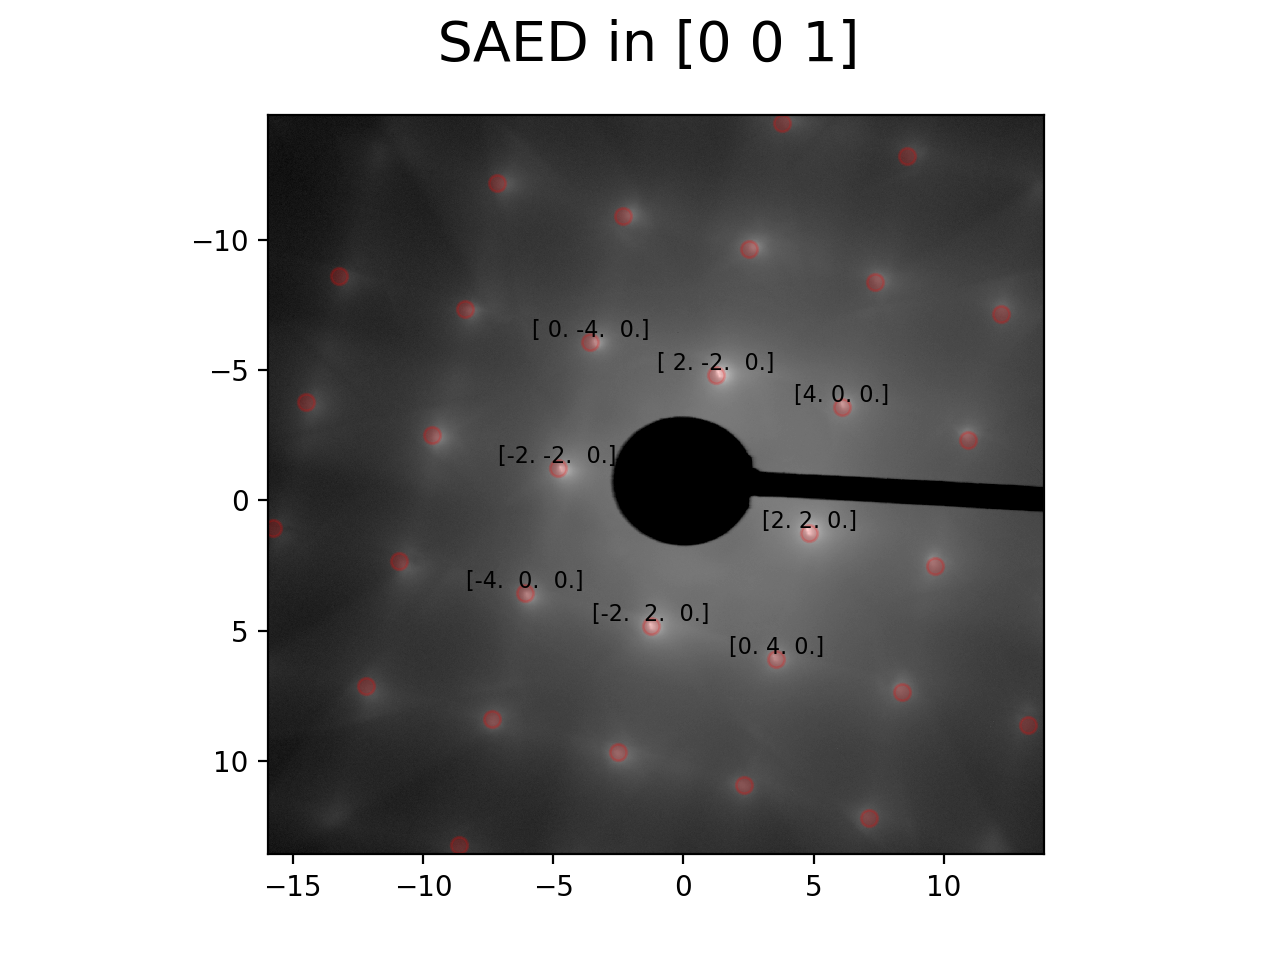

In [27]:
g = gx = gy = pattern_tags['axis']['0']['scale']
g = gx = gy = scale_300mm*1.08
gx = gy * 1.05

extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

angle = np.radians(-59.6)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rmat_g= r_mat

spots_simulation =  np.dot(tags_simulation['allowed']['g'],r_mat)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]
fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_simulation['zone_hkl']), fontsize=20) 
plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
#plt.scatter(spots_experiment[:,1], spots_experiment[:,0], c='blue',  alpha = 0.5, label='spots')
plt.imshow(np.log2(1+diff_pattern),cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5);

for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <8:
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
    

## What does the above figure convey?

* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?
* diffraction pattern is indexed



# What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattce parameter better than 1% if we use high scattering angles!

Objective stigmation is critical to resolve angles well.

Illumination stigmation determines size of Bragg spots.


## Conclusion

We need more information for the spot pattern than for the ring pattern.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you.



## Back: [Kinematic Scattering Geometry](Kinematic_Scattering_Geometry.ipynb)
## Next: [Kikuchi Lines](Kikuchi_Lines.ipynb)
## Chapter 2: [Diffraction](Diffraction.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)

reciprocal_unit_cell
[[1.764 0.    0.   ]
 [0.    1.764 0.   ]
 [0.    0.    1.764]]
The inner potential is 0.001kV
Magnitude of incident wave vector in material 205.5 1/nm and vacuum 205.5 1/nm
The convergence angle of 0mrad = 0.00 1/nm
Rotation angles are 45.0 deg and 90.0 deg
Center of Ewald sphere  [-2.39288115e-14  8.89798152e-15  2.05506537e+02]
Of the 29790 tested reciprocal_unit_cell points, 546 have an excitation error less than 0.40 1/nm
Of the 546 possible reflection 114 are allowed.
 There are 46 allowed reflections in the zero order Laue Zone
 There are 0 allowed reflections in the first order Laue Zone
 There are 68 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the other higher order Laue Zones
Length of zone axis vector in real space 0.802 nm
There are 16 forbidden but dynamical activated diffraction spots:
KinsCat's  "Kinematic_Scattering" finished


<IPython.core.display.Javascript object>


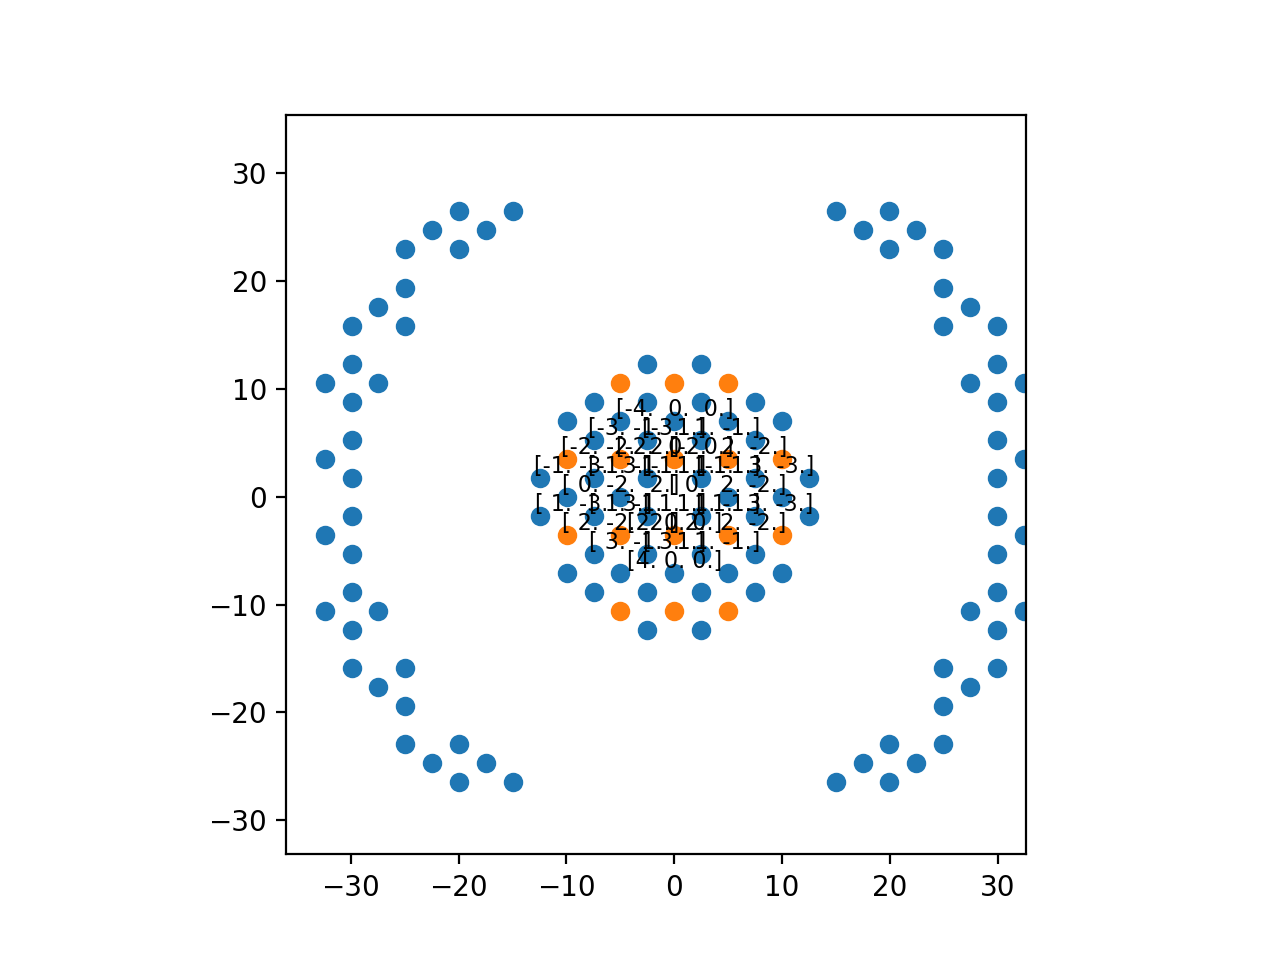

In [38]:
######################################
# Diffraction Simulation of Crystal #
######################################
tags_simulation['zone_hkl'] = np.array([0,1,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_simulation['acceleration_voltage_V'] = 60.0 *1000.0 #V
ks.Kinematic_Scattering(tags_simulation, verbose = True)
plt.figure()
plt.scatter(tags_simulation['allowed']['g'][:,0],tags_simulation['allowed']['g'][:,1])
dynamic_allowed = tags_simulation['forbidden']['g'][tags_simulation['forbidden']['dynamically_activated']]
plt.scatter(dynamic_allowed[:,0],dynamic_allowed[:,1])


for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <8:
        plt.text(tags_simulation['allowed']['g'][i,0], tags_simulation['allowed']['g'][i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')

for i in range(len(dynamic_allowed)):
    if np.linalg.norm(dynamic_allowed[i]) <8:
        plt.text(dynamic_allowed[i,0], dynamic_allowed[i,1],str(tags_simulation['forbidden']['hkl'][tags_simulation['forbidden']['dynamically_activated'][i]]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.gca().set_aspect('equal')
